In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams.update({'font.size': 22})

## Functions

In [13]:
def pearson_corr(df: pd.DataFrame, x: str, y: str) -> float:
    sub = df[[x, y]].dropna()
    if len(sub) < 2:
        return np.nan
    return sub.corr().iloc[0, 1] ## off-diagonal = correlation

def annotate_corr(data, color, **kws):
    ax = plt.gca()
    sub_df = data[['csif', 'yield']].dropna()
    if len(sub_df) >= 2:
        r, _ = stats.pearsonr(sub_df['csif'], sub_df['yield'])
        ax.annotate(f"r = {r:.2f}",
            xy=(0.08, 0.90), xycoords=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

def plot_yield_secondary(data, color, **kws):
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x="year", y="yield", ax=ax2, lw=2, ci=None, color="black")
    ax2.set_ylabel("")  
    if data['year'].notna().any():
        xmin, xmax = np.nanmin(data['year']), np.nanmax(data['year'])
        ax1.set_xlim(xmin, xmax)
        xticks = np.linspace(round(xmin), round(xmax), num=3, dtype=int)
        ax1.set_xticks(xticks)
        ax1.set_xticklabels([str(t) for t in xticks])

def plot_master(data, col_order, colors, col_wrap, **kws):
    g = sns.FacetGrid(data,
        col="cropname", hue="cropname",
        col_order= col_order, 
        col_wrap= col_wrap,
        height=4, aspect= 1.4,
        sharey=False,
        palette=colors,
        despine=False)
    
    g.map_dataframe(sns.lineplot, x="year", y="csif", lw=3, ci=None)

    for ax in g.axes.flat:
        ax.tick_params(axis='y', colors='red')
        ax.set_ylabel("", color='red')

    g.map_dataframe(annotate_corr)
    g.map_dataframe(plot_yield_secondary)
    g.set_axis_labels("", "")
    g.set_titles(col_template="{col_name}", size=18)

    g.fig.text(0.5, 0.035, 'Year', ha='center', va='center')
    g.fig.text(0.03, 0.5, 'Satellite-derived yields (log, dt)', ha='center', va='center',
            rotation='vertical', color="red")
    g.fig.text(0.985, 0.5, 'Survey-derived yields (log, dt)', ha='center', va='center',
            rotation='-90')

    g.fig.tight_layout(rect=[0.05, 0.06, 0.96, 0.97])
    plt.show()

# Input data

In [ ]:
combined = pd.read_pickle("./data/combined_update_dt.pkl").dropna()
usa = combined[combined['country']=="United States of America"]

corrs = (usa.groupby("cropname", group_keys=False)
         .apply(lambda d: pearson_corr(d, "csif", "yield"))
         .sort_values(ascending=False))

sorted_crops = corrs.index.tolist()


# Plot

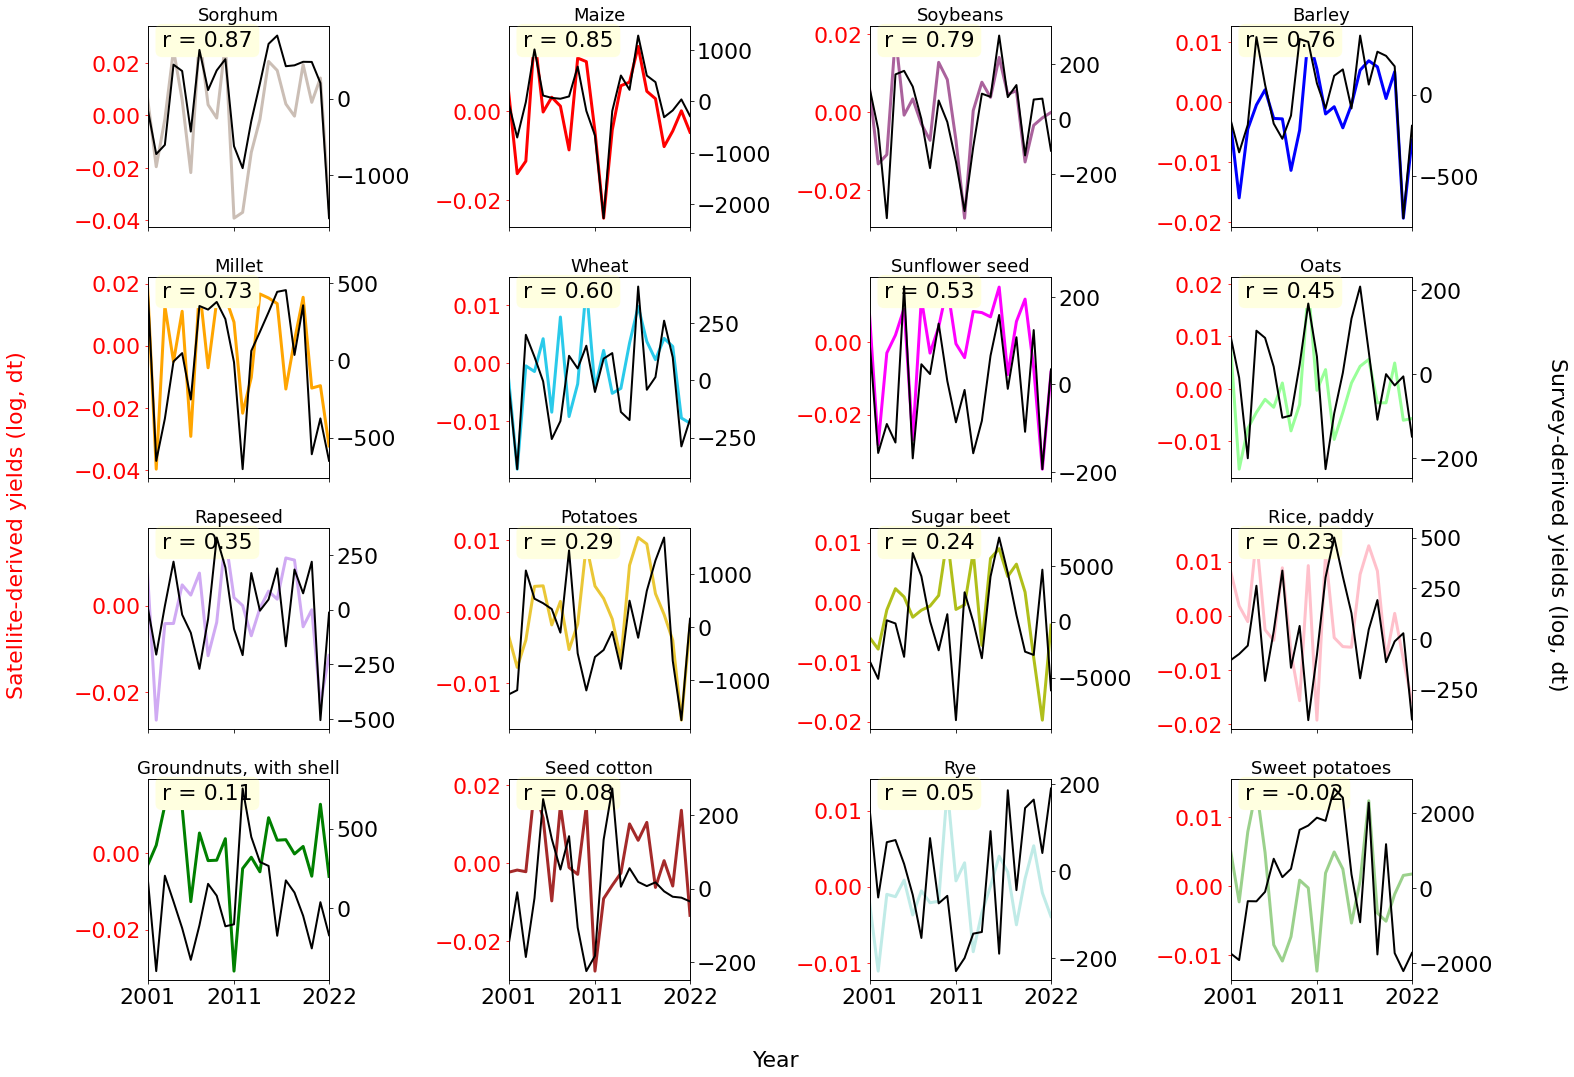

In [19]:
colors1 = ["blue", "green", "red", "orange", "#98ff98", "#eac736", "#d0aaf3", "pink", "#c0ebe7", "brown", "#cbbeb5", "#aa629c", "#b0bf1a", "#ff00ff", "#9bd18c", "#2acaea"]
plot_master(usa, sorted_crops, colors1, col_wrap=4)

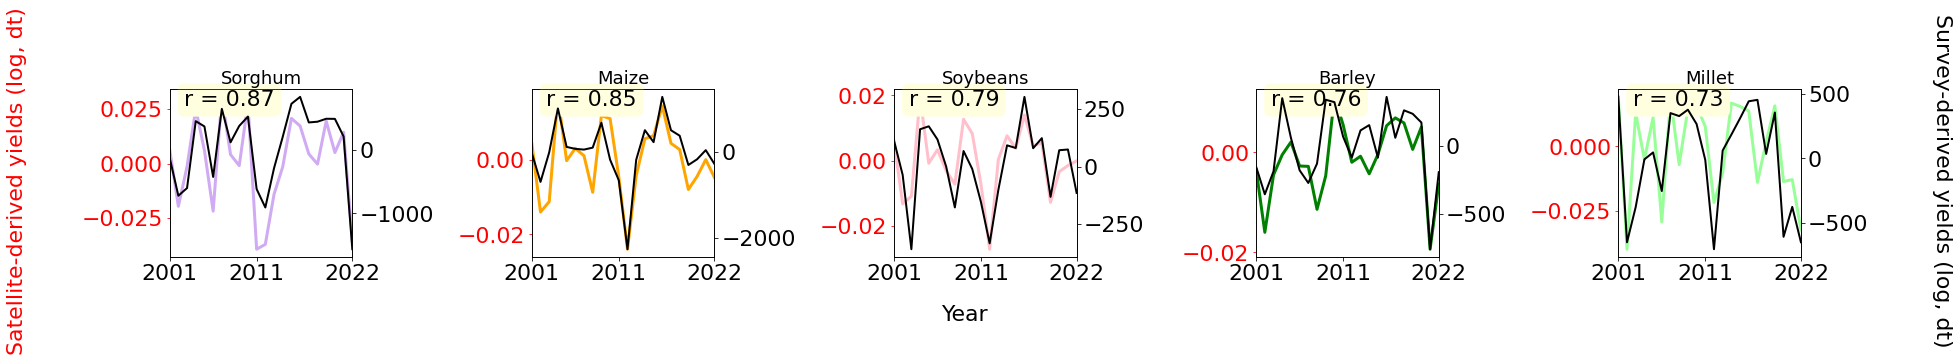

In [20]:
colors2 = ["green", "orange", "#98ff98", "#d0aaf3", "pink"]
best = usa[usa['cropname'].isin(sorted_crops[:5])]
plot_master(best, sorted_crops[:5], colors2, col_wrap=5)

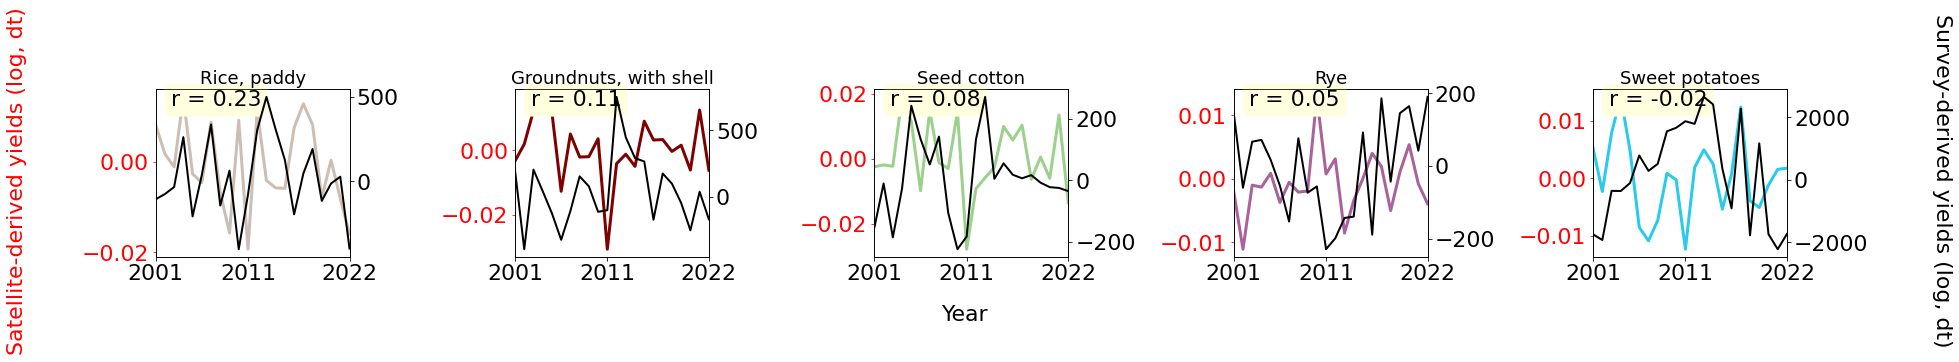

In [21]:
colors3 = ["maroon", "#cbbeb5", "#aa629c", "#9bd18c", "#2acaea"]
worst = usa[usa['cropname'].isin(sorted_crops[-5:])]
plot_master(worst, sorted_crops[-5:], colors3, col_wrap=5)

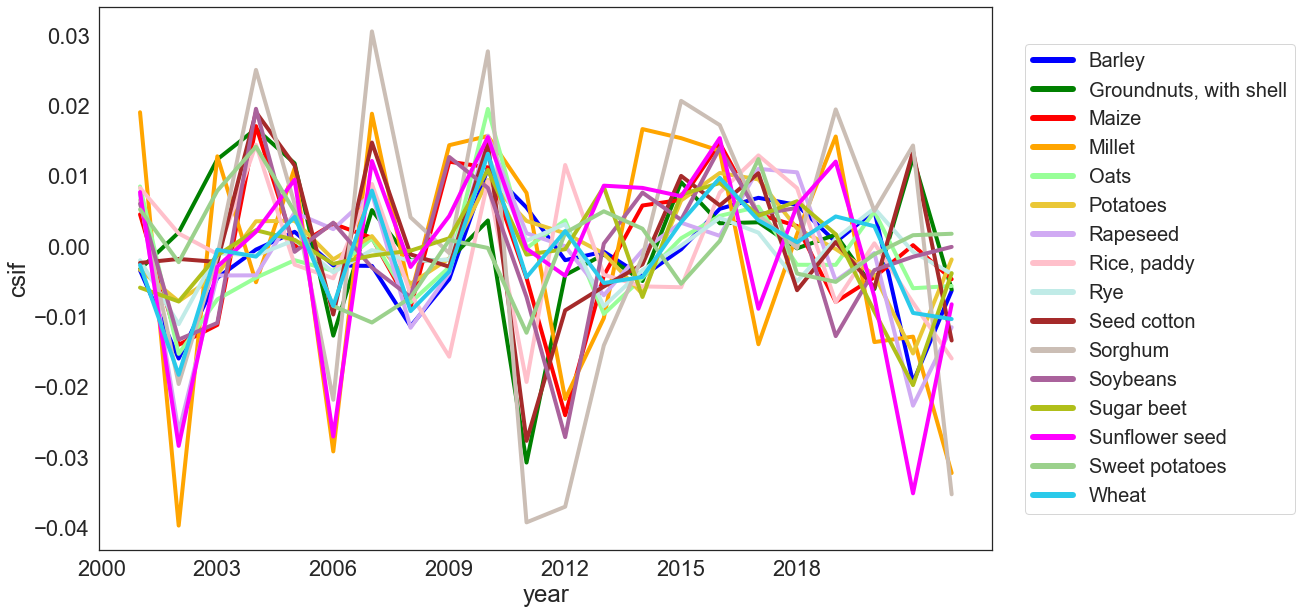

In [24]:
cropnum = len(np.unique(usa['cropname']))
allcrop = usa.copy()
plt.figure(figsize=(16, 10))
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(x='year', y='csif', hue='cropname', data=allcrop, palette=colors1, lw=4)
ax.set(xticks=list( [2000,2003,2006, 2009, 2012, 2015, 2018]))
leg = ax.legend()
for line in leg.get_lines():
    line.set_linewidth(6)
sns.move_legend(ax, "center right",  bbox_to_anchor=(1.35, 0.5), fontsize=20)
plt.savefig("./plots/usa_spaghetti.pdf")